<a href="https://colab.research.google.com/github/Arindam-Jain/Kaggle-Competitions/blob/master/birdsong_recognition_train_01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"jainarindam","key":"a30deddcac51aef0cab7b7171309abb3"}'}

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets list

ref                                                               title                                              size  lastUpdated          downloadCount  
----------------------------------------------------------------  ------------------------------------------------  -----  -------------------  -------------  
Cornell-University/arxiv                                          arXiv Dataset                                     877MB  2020-08-14 23:50:57           1781  
agirlcoding/all-space-missions-from-1957                          All Space Missions from 1957                      101KB  2020-08-13 16:18:58            812  
landlord/handwriting-recognition                                  Handwriting Recognition                             1GB  2020-08-05 17:20:36            270  
jmmvutu/summer-products-and-sales-in-ecommerce-wish               Sales of summer clothes in E-commerce Wish        351KB  2020-08-06 22:27:25            764  
andrewmvd/heart-failure-clinical-data   

In [7]:
! kaggle datasets download -d ttahara/birdsong-resampled-train-audio-01

100% 9.25G/9.25G [03:54<00:00, 33.4MB/s]
100% 9.25G/9.25G [03:54<00:00, 42.3MB/s]


In [8]:
!ls

birdsong-resampled-train-audio-01.zip  kaggle.json  sample_data


In [9]:
!mkdir train_new  #create a directory named train/
!unzip -q /content/birdsong-resampled-train-audio-01.zip -d train_new/  #unzip data in train/

In [10]:
!rm /content/birdsong-resampled-train-audio-01.zip

In [11]:
import matplotlib.pyplot as plt
from scipy.io import wavfile
import argparse
import os
from glob import glob
import numpy as np
import pandas as pd
from librosa.core import resample, to_mono
from tqdm import tqdm
from pathlib import Path
import librosa
import librosa.display
from tqdm import tqdm_notebook as tqdm
from IPython.display import Audio, IFrame, display

In [12]:

import warnings
warnings.filterwarnings('ignore')
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window=int(rate/20),
                       min_periods=1,
                       center=True).max()

    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    #eww=mask
    #eww=np.asarray(eww)
    #print(np.unique(eww,return_counts=True))
    return mask, y_mean


def downsample_mono(path, sr):
    rate, wav = wavfile.read(path)
    wav = wav.astype(np.float32, order='F')
    try:
        tmp = wav.shape[1]
        wav = to_mono(wav.T)
    except:
        pass
    wav = resample(wav, rate, sr)
    wav = wav.astype(np.int16)
    return sr, wav


def save_sample(sample, rate, target_dir, fn, ix):
    fn = fn.split('.wav')[0]
    dst_path = os.path.join(target_dir.split('.')[0], fn+'_{}.wav'.format(str(ix)))
    if os.path.exists(dst_path):
        return
    wavfile.write(dst_path, rate, sample)


def check_dir(path):
    if os.path.exists(path) is False:
        os.mkdir(path)

def get_audio(row_number):
    return display(Audio(audio_path))        

def split_wavs(args):
    src_root = args.src_root
    dst_root = args.dst_root
    dt = args.delta_time

    wav_paths = glob('{}/**'.format(src_root), recursive=True)
    wav_paths = [x for x in wav_paths if '.wav' in x]
    print(wav_paths)
    dirs = os.listdir(src_root)
    check_dir(dst_root)
    classes = os.listdir(src_root)
    for _cls in classes:
        target_dir = os.path.join(dst_root, _cls)
        check_dir(target_dir)
        src_dir = os.path.join(src_root, _cls)
        for fn in tqdm(os.listdir(src_dir)):
            src_fn = os.path.join(src_dir, fn)
            rate, wav = downsample_mono(src_fn, args.sr)
            mask, y_mean = envelope(wav, rate, threshold=args.threshold)
            wav = wav[mask]
            delta_sample = int(dt*rate)

            # cleaned audio is less than a single sample
            # pad with zeros to delta_sample size
            if wav.shape[0] < delta_sample:
                sample = np.zeros(shape=(delta_sample,), dtype=np.int16)
                sample[:wav.shape[0]] = wav
                save_sample(sample, rate, target_dir, fn, 0)
            # step through audio and save every delta_sample
            # discard the ending audio if it is too short
            else:
                trunc = wav.shape[0] % delta_sample
                for cnt, i in enumerate(np.arange(0, wav.shape[0]-trunc, delta_sample)):
                    start = int(i)
                    stop = int(i + delta_sample)
                    sample = wav[start:stop]
                    save_sample(sample, rate, target_dir, fn, cnt)


def test_threshold(args):
    src_root = args.src_root
    wav_paths = glob('{}/**'.format(src_root), recursive=True)
    wav_path = [x for x in wav_paths if args.fn in x]
    if len(wav_path) != 1:
        print('audio file not found for sub-string: {}'.format(args.fn))
        return
    rate, wav = downsample_mono(wav_path[0], args.sr)
    mask, env = envelope(wav, rate, threshold=args.threshold)
    plt.style.use('ggplot')
    plt.title('Signal Envelope, Threshold = {}'.format(str(args.threshold)))
    plt.plot(wav, color='g', label='original')
    plt.plot(env, color='y', label='envelope')
    plt.plot(wav[mask], color='c', label='keep')
    plt.plot(wav[np.logical_not(mask)], color='r', label='remove')
    plt.grid(False)
    plt.legend(loc='best')
    plt.show()
    print("Original- Tape Recoder Audio")
    display(Audio(wav, rate=rate))
    print("Noise(removed)- Red")
    display(Audio(wav[np.logical_not(mask)], rate=rate))
    print("Pure Bird Call(saved)- Blue")
    display(Audio(wav[mask], rate=rate))

if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='Cleaning audio data')
    parser.add_argument('--src_root', type=str, default='/content/train_new',
                        help='directory of audio files in total duration')
    parser.add_argument('--dst_root', type=str, default='clean',
                        help='directory to put audio files split by delta_time')
    parser.add_argument('--delta_time', '-dt', type=float, default=1.0,
                        help='time in seconds to sample audio')
    parser.add_argument('--sr', type=int, default=32000,
                        help='rate to downsample audio')

    parser.add_argument('--fn', type=str, default='XC101583.wav',
                        help='file to plot over time to check magnitude')
    parser.add_argument('--threshold', type=str, default=500,
                        help='threshold magnitude for np.int16 dtype')
    args, _ = parser.parse_known_args()

    #test_threshold(args)
    split_wavs(args)    

['/content/train_new/chispa/XC444639.wav', '/content/train_new/chispa/XC372203.wav', '/content/train_new/chispa/XC376219.wav', '/content/train_new/chispa/XC379019.wav', '/content/train_new/chispa/XC412683.wav', '/content/train_new/chispa/XC125194.wav', '/content/train_new/chispa/XC325938.wav', '/content/train_new/chispa/XC498249.wav', '/content/train_new/chispa/XC182933.wav', '/content/train_new/chispa/XC188824.wav', '/content/train_new/chispa/XC169162.wav', '/content/train_new/chispa/XC416327.wav', '/content/train_new/chispa/XC189062.wav', '/content/train_new/chispa/XC188094.wav', '/content/train_new/chispa/XC311994.wav', '/content/train_new/chispa/XC141462.wav', '/content/train_new/chispa/XC313309.wav', '/content/train_new/chispa/XC361007.wav', '/content/train_new/chispa/XC363865.wav', '/content/train_new/chispa/XC328414.wav', '/content/train_new/chispa/XC109311.wav', '/content/train_new/chispa/XC476560.wav', '/content/train_new/chispa/XC467080.wav', '/content/train_new/chispa/XC4670

In [13]:
from tensorflow.keras import layers
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.regularizers import l2
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
import tensorflow as tf
import os


def Conv1D(N_CLASSES=10, SR=32000, DT=1.0):
    i = layers.Input(shape=(1, int(SR*DT)), name='input')
    x = Melspectrogram(n_dft=512, n_hop=160,
                       padding='same', sr=SR, n_mels=128,
                       fmin=0.0, fmax=SR/2, power_melgram=2.0,
                       return_decibel_melgram=True, trainable_fb=False,
                       trainable_kernel=False,
                       name='melbands')(i)
    x = Normalization2D(str_axis='batch', name='batch_norm')(x)
    x = layers.Permute((2,1,3), name='permute')(x)
    x = TimeDistributed(layers.Conv1D(8, kernel_size=(4), activation='tanh'), name='td_conv_1d_tanh')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), name='max_pool_2d_1')(x)
    x = TimeDistributed(layers.Conv1D(16, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_1')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), name='max_pool_2d_2')(x)
    x = TimeDistributed(layers.Conv1D(32, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_2')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), name='max_pool_2d_3')(x)
    x = TimeDistributed(layers.Conv1D(64, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_3')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), name='max_pool_2d_4')(x)
    x = TimeDistributed(layers.Conv1D(128, kernel_size=(4), activation='relu'), name='td_conv_1d_relu_4')(x)
    x = layers.GlobalMaxPooling2D(name='global_max_pooling_2d')(x)
    x = layers.Dropout(rate=0.1, name='dropout')(x)
    x = layers.Dense(64, activation='relu', activity_regularizer=l2(0.001), name='dense')(x)
    o = layers.Dense(N_CLASSES, activation='softmax', name='softmax')(x)

    model = Model(inputs=i, outputs=o, name='1d_convolution')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


def Conv2D(N_CLASSES=10, SR=16000, DT=1.0):
    i = layers.Input(shape=(1, int(SR*DT)), name='input')
    x = Melspectrogram(n_dft=512, n_hop=160,
                       padding='same', sr=SR, n_mels=128,
                       fmin=0.0, fmax=SR/2, power_melgram=2.0,
                       return_decibel_melgram=True, trainable_fb=False,
                       trainable_kernel=False,
                       name='melbands')(i)
    x = Normalization2D(str_axis='batch', name='batch_norm')(x)
    x = layers.Conv2D(8, kernel_size=(7,7), activation='tanh', padding='same', name='conv2d_tanh')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_1')(x)
    x = layers.Conv2D(16, kernel_size=(5,5), activation='relu', padding='same', name='conv2d_relu_1')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_2')(x)
    x = layers.Conv2D(16, kernel_size=(3,3), activation='relu', padding='same', name='conv2d_relu_2')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_3')(x)
    x = layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', name='conv2d_relu_3')(x)
    x = layers.MaxPooling2D(pool_size=(2,2), padding='same', name='max_pool_2d_4')(x)
    x = layers.Conv2D(32, kernel_size=(3,3), activation='relu', padding='same', name='conv2d_relu_4')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dropout(rate=0.2, name='dropout')(x)
    x = layers.Dense(64, activation='relu', activity_regularizer=l2(0.001), name='dense')(x)
    o = layers.Dense(N_CLASSES, activation='softmax', name='softmax')(x)

    model = Model(inputs=i, outputs=o, name='2d_convolution')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model


def LSTM(N_CLASSES=10, SR=32000, DT=1.0):
    i = layers.Input(shape=(1, int(SR*DT)), name='input')
    x = Melspectrogram(n_dft=512, n_hop=160,
                       padding='same', sr=SR, n_mels=128,
                       fmin=0.0, fmax=SR/2, power_melgram=2.0,
                       return_decibel_melgram=True, trainable_fb=False,
                       trainable_kernel=False,
                       name='melbands')(i)
    x = Normalization2D(str_axis='batch', name='batch_norm')(x)
    x = layers.Permute((2,1,3), name='permute')(x)
    x = TimeDistributed(layers.Reshape((-1,)), name='reshape')(x)
    s = TimeDistributed(layers.Dense(64, activation='tanh'),
                        name='td_dense_tanh')(x)
    x = layers.Bidirectional(layers.LSTM(32, return_sequences=True),
                             name='bidirectional_lstm')(s)
    x = layers.concatenate([s, x], axis=2, name='skip_connection')
    x = layers.Dense(64, activation='relu', name='dense_1_relu')(x)
    x = layers.MaxPooling1D(name='max_pool_1d')(x)
    x = layers.Dense(32, activation='relu', name='dense_2_relu')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dropout(rate=0.2, name='dropout')(x)
    x = layers.Dense(32, activation='relu',
                         activity_regularizer=l2(0.001),
                         name='dense_3_relu')(x)
    o = layers.Dense(N_CLASSES, activation='softmax', name='softmax')(x)

    model = Model(inputs=i, outputs=o, name='long_short_term_memory')
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [15]:
import tensorflow as tf
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import os
from scipy.io import wavfile
import pandas as pd
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from glob import glob
import argparse
import warnings


class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, wav_paths, labels, sr, dt, n_classes,
                 batch_size=32, shuffle=True):
        self.wav_paths = wav_paths
        self.labels = labels
        self.sr = sr
        self.dt = dt
        self.n_classes = n_classes
        self.batch_size = batch_size
        self.shuffle = True
        self.on_epoch_end()


    def __len__(self):
        return int(np.floor(len(self.wav_paths) / self.batch_size))


    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        wav_paths = [self.wav_paths[k] for k in indexes]
        labels = [self.labels[k] for k in indexes]

        # generate a batch of time data
        X = np.empty((self.batch_size, 1, int(self.sr*self.dt)), dtype=np.float32)
        Y = np.empty((self.batch_size, self.n_classes), dtype=np.float32)

        for i, (path, label) in enumerate(zip(wav_paths, labels)):
            rate, wav = wavfile.read(path)
            X[i,] = wav.reshape(1, -1)
            Y[i,] = to_categorical(label, num_classes=self.n_classes)

        return X, Y


    def on_epoch_end(self):
        self.indexes = np.arange(len(self.wav_paths))
        if self.shuffle:
            np.random.shuffle(self.indexes)


def train(args):
    src_root = args.src_root
    sr = args.sample_rate
    dt = args.delta_time
    batch_size = args.batch_size
    model_type = args.model_type
    params = {'N_CLASSES':len(os.listdir(args.src_root)),
              'SR':sr,
              'DT':dt}
    models = {'conv1d':Conv1D(**params),
              'conv2d':Conv2D(**params),
              'lstm':  LSTM(**params)}
    assert model_type in models.keys(), '{} not an available model'.format(model_type)
    csv_path = os.path.join('/content/logs', '{}_history.csv'.format(model_type))

    wav_paths = glob('{}/**'.format(src_root), recursive=True)
    wav_paths = [x.replace(os.sep, '/') for x in wav_paths if '.wav' in x]
    classes = sorted(os.listdir(args.src_root))
    le = LabelEncoder()
    le.fit(classes)
    labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]
    labels = le.transform(labels)
    wav_train, wav_val, label_train, label_val = train_test_split(wav_paths,
                                                                  labels,
                                                                  test_size=0.1,
                                                                  random_state=0)

    assert len(label_train) >= args.batch_size, 'Number of train samples must be >= batch_size'
    if len(set(label_train)) != params['N_CLASSES']:
        warnings.warn('Found {}/{} classes in training data. Increase data size or change random_state.'.format(len(set(label_train)), params['N_CLASSES']))
    if len(set(label_val)) != params['N_CLASSES']:
        warnings.warn('Found {}/{} classes in validation data. Increase data size or change random_state.'.format(len(set(label_val)), params['N_CLASSES']))

    tg = DataGenerator(wav_train, label_train, sr, dt,
                       params['N_CLASSES'], batch_size=batch_size)
    vg = DataGenerator(wav_val, label_val, sr, dt,
                       params['N_CLASSES'], batch_size=batch_size)
    model = models[model_type]
    cp = ModelCheckpoint('models/{}.h5'.format(model_type), monitor='val_loss',
                         save_best_only=True, save_weights_only=False,
                         mode='auto', save_freq='epoch', verbose=1)
    csv_logger = CSVLogger(csv_path, append=False)
    model.fit(tg, validation_data=vg,
              epochs=30, verbose=1, workers=2,
              callbacks=[csv_logger, cp])


if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='Audio Classification Training')
    parser.add_argument('--model_type', type=str, default='conv2d',
                        help='model to run. i.e. conv1d, conv2d, lstm')
    parser.add_argument('--src_root', type=str, default='/content/clean',
                        help='directory of audio files in total duration')
    parser.add_argument('--batch_size', type=int, default=32,
                        help='batch size')
    parser.add_argument('--delta_time', '-dt', type=float, default=1.0,
                        help='time in seconds to sample audio')
    parser.add_argument('--sample_rate', '-sr', type=int, default=32000,
                        help='sample rate of clean audio')
    args, _ = parser.parse_known_args()

    train(args)

Epoch 1/30
1364/1364 [==============================] - ETA: 0s - loss: 2.0798 - accuracy: 0.3777
Epoch 00001: val_loss improved from inf to 1.67909, saving model to models/conv2d.h5
1364/1364 [==============================] - 55s 40ms/step - loss: 2.0798 - accuracy: 0.3777 - val_loss: 1.6791 - val_accuracy: 0.5089
Epoch 2/30
1361/1364 [============================>.] - ETA: 0s - loss: 1.6190 - accuracy: 0.5254
Epoch 00002: val_loss improved from 1.67909 to 1.53901, saving model to models/conv2d.h5
1364/1364 [==============================] - 23s 17ms/step - loss: 1.6190 - accuracy: 0.5255 - val_loss: 1.5390 - val_accuracy: 0.5433
Epoch 3/30
1364/1364 [==============================] - ETA: 0s - loss: 1.4450 - accuracy: 0.5768
Epoch 00003: val_loss improved from 1.53901 to 1.34527, saving model to models/conv2d.h5
1364/1364 [==============================] - 23s 17ms/step - loss: 1.4450 - accuracy: 0.5768 - val_loss: 1.3453 - val_accuracy: 0.6066
Epoch 4/30
1364/1364 [================

In [16]:
log_csvs = sorted(os.listdir('/content/logs'))
print(log_csvs)

['conv2d_history.csv']


In [17]:
labels = ['Conv 2D']
colors = ['r']

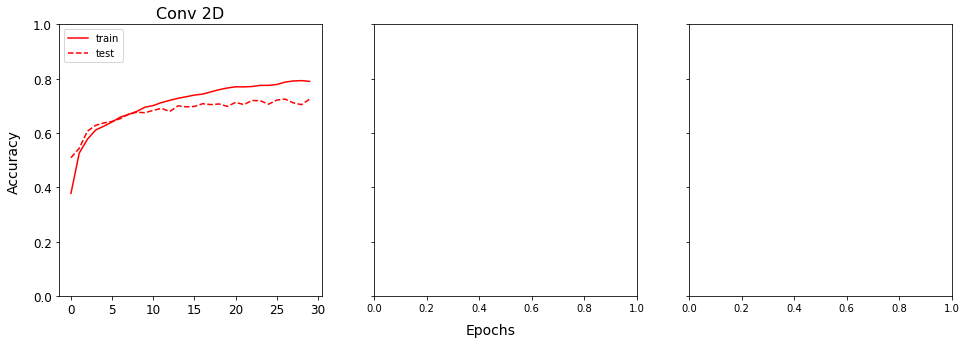

In [21]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(16,5))

for i, (fn, label, c) in enumerate(zip('/content/logs', labels, colors)):
    csv_path = os.path.join('..', 'logs', fn)
    df = pd.read_csv('/content/logs/conv2d_history.csv')
    ax[i].set_title(label, size=16)
    ax[i].plot(df.accuracy, color=c, label='train')
    ax[i].plot(df.val_accuracy, ls='--', color=c, label='test')
    ax[i].legend(loc='upper left')
    ax[i].tick_params(axis='both', which='major', labelsize=12)
    ax[i].set_ylim([0,1.0])

fig.text(0.5, 0.02, 'Epochs', ha='center', size=14)
fig.text(0.08, 0.5, 'Accuracy', va='center', rotation='vertical', size=14)
plt.show()

## Predictions

In [ ]:

from tensorflow.keras.models import load_model
from clean import downsample_mono, envelope
from kapre.time_frequency import Melspectrogram
from kapre.utils import Normalization2D
from sklearn.preprocessing import LabelEncoder
import numpy as np
from glob import glob
import argparse
import os
import pandas as pd
from tqdm import tqdm


def make_prediction(args):

    model = load_model(args.model_fn,
        custom_objects={'Melspectrogram':Melspectrogram,
                        'Normalization2D':Normalization2D})

    wav_paths = glob('{}/**'.format(args.src_dir), recursive=True)
    wav_paths = sorted([x.replace(os.sep, '/') for x in wav_paths if '.wav' in x])
    classes = sorted(os.listdir(args.src_dir))
    labels = [os.path.split(x)[0].split('/')[-1] for x in wav_paths]
    le = LabelEncoder()
    y_true = le.fit_transform(labels)
    results = []

    for z, wav_fn in tqdm(enumerate(wav_paths), total=len(wav_paths)):
        rate, wav = downsample_mono(wav_fn, args.sr)
        mask, env = envelope(wav, rate, threshold=args.threshold)
        clean_wav = wav[mask]
        step = int(args.sr*args.dt)
        batch = []

        for i in range(0, clean_wav.shape[0], step):
            sample = clean_wav[i:i+step]
            sample = sample.reshape(1,-1)
            if sample.shape[0] < step:
                tmp = np.zeros(shape=(1,step), dtype=np.float32)
                tmp[:,:sample.shape[1]] = sample.flatten()
                sample = tmp
            batch.append(sample)
        X_batch = np.array(batch, dtype=np.float32)
        y_pred = model.predict(X_batch)
        y_mean = np.mean(y_pred, axis=0)
        y_pred = np.argmax(y_mean)
        real_class = os.path.dirname(wav_fn).split('/')[-1]
        print('Actual class: {}, Predicted class: {}'.format(real_class, classes[y_pred]))
        results.append(y_mean)

    np.save(os.path.join('logs', args.pred_fn), np.array(results))


if __name__ == '__main__':

    parser = argparse.ArgumentParser(description='Audio Classification Training')
    parser.add_argument('--model_fn', type=str, default='models/lstm.h5',
                        help='model file to make predictions')
    parser.add_argument('--pred_fn', type=str, default='y_pred',
                        help='fn to write predictions in logs dir')
    parser.add_argument('--src_dir', type=str, default='wavfiles',
                        help='directory containing wavfiles to predict')
    parser.add_argument('--dt', type=float, default=1.0,
                        help='time in seconds to sample audio')
    parser.add_argument('--sr', type=int, default=16000,
                        help='sample rate of clean audio')
    parser.add_argument('--threshold', type=str, default=20,
                        help='threshold magnitude for np.int16 dtype')
    args, _ = parser.parse_known_args()

    make_prediction(args)